In [1]:
import numpy
from matplotlib import pyplot as plt
from matplotlib import rcParams

In [2]:
def readpqr(filename, N):
    '''
    Reads a pqr file and returns the atom names, coordinates, and charges.    
    '''
    pqr_file = open(filename,'r')
    
    position = numpy.zeros((N,3))
    q = numpy.zeros(N)
    amino_acid_name = numpy.array(q, dtype=numpy.string_)
    atom_name = numpy.array(q, dtype=numpy.string_)
    chain = numpy.array(q, dtype=numpy.string_)
    amino_acid_number = numpy.zeros(N, dtype=int)
    
    counter = 0
    for i, line in enumerate(pqr_file):
        line_split = line.split()
        if line_split[0] == 'ATOM':
            position[counter,0] = float(line_split[6])
            position[counter,1] = float(line_split[7])
            position[counter,2] = float(line_split[8])
            q[counter] = float(line_split[9])
            amino_acid_name[counter] = line_split[3]
            amino_acid_number[counter] = int(line_split[5])
            atom_name[counter] = line_split[2]
            chain[counter] = line_split[4]
            counter += 1
        
    return position, q, amino_acid_name, amino_acid_number, atom_name,chain

def compute_force(dphi, q):
    '''
    Computes the electrostatic force on each atom due to the repulsion of the other atoms.
    '''
    
    force = -numpy.transpose(numpy.transpose(dphi)*q)
    force_magnitude = numpy.sqrt(numpy.sum(force**2, axis=1))
    
    total_force = numpy.sum(force, axis=0)
    total_force_magnitude = numpy.sqrt(numpy.sum(total_force**2))

    C0 = 69.467*4*numpy.pi*332.0636817823836
    return C0*force, C0*force_magnitude, C0*total_force, C0*total_force_magnitude

In [3]:
# Read dphir files from Pygbe
folder='zika_afm\\tip_charge-2.5_rad150\\zatsc' #Cambiar segun archivos
dphi_386c = numpy.loadtxt(folder+'386/dphir.txt')   # d=0.2nm
dphi_390c = numpy.loadtxt(folder+'390/dphir.txt')   # d=0.6nm
dphi_394c = numpy.loadtxt(folder+'394/dphir.txt')   # d=1.0nm
dphi_404c = numpy.loadtxt(folder+'404/dphir.txt')   # d=2.0nm
dphi_484c = numpy.loadtxt(folder+'484/dphir.txt')   # d=10.0nm
dphi_1384c = numpy.loadtxt(folder+'1384/dphir.txt') # d=100.0nm

# Read pqr file and calculate forces
N = len(dphi_390c)
position, q, amino_acid_name, amino_acid_number, atom_name,chain = readpqr('zika_afm\\ZIKV_6CO8_aa_charge_vdw_addspace.pqr',N)
delta_dphi_386_local = dphi_386c - dphi_1384c
fl_386, fl_mag_386, Fl_386, Fl_mag_386 = compute_force(delta_dphi_386_local, q)

<Figure size 432x288 with 0 Axes>

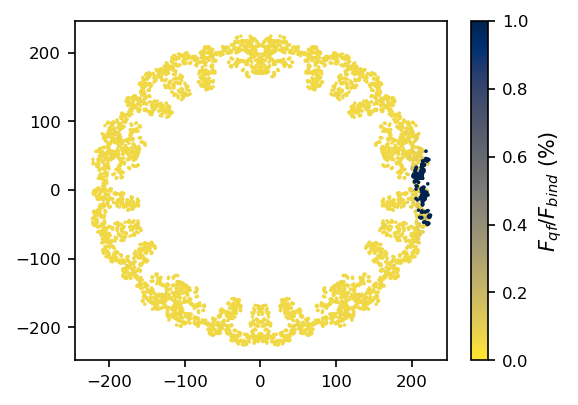

In [39]:
# Force qf plot for plane x-y (z=0) for capsid
# Select plane for the plot
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8
plane = 0#-145.25
near_plane = numpy.where(abs(position[:,2]-plane)<0.5)[0]
near_plane2 = numpy.where(abs(position[:,2]-plane)<2.5)[0]
f_tot_mag_386 = numpy.sqrt((-2.1197685475579964)**2+(0.36092747252832624)**2+(0.00760169067022572)**2)


# Plotting
x = position[near_plane,0]
y = position[near_plane,1]
x2 = position[near_plane2,0]
y2 = position[near_plane2,1]
f_porcent = 100*(fl_mag_386[near_plane])/(f_tot_mag_386) #Force percentage
f_porcent2 = 100*(fl_mag_386[near_plane2])/(f_tot_mag_386) #Force percentage
f_greater  = numpy.where(f_porcent2 > 1)[0] #Detect forces greater than 1% of the total force
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(x,y,c=f_porcent,s=0.5, cmap='cividis_r',vmin=-0.3)
plt.scatter(x2[f_greater],y2[f_greater],c=f_porcent2[f_greater],cmap='cividis_r',s=0.5,vmin=0,vmax=1.0)
color = plt.colorbar(label=r'$F_{qf}/F_{bind}$ (%) ', )
plt.savefig('plots\\forces_qf_condelta_cuadrado.pdf', format='pdf',dpi=300,bbox_inches='tight')

In [36]:
len(near_plane)

22883

<Figure size 432x288 with 0 Axes>

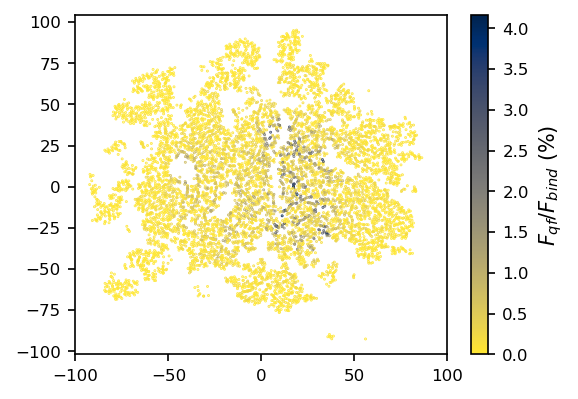

In [31]:
# Force qf plot for plane y-z (x=210) for capsid
# Select plane for the plot
plane = 210#-145.25
near_plane = numpy.where(abs(position[:,0]-plane)<2.5)[0]
f_tot_mag_386 = numpy.sqrt((-2.1197685475579964)**2+(0.36092747252832624)**2+(0.00760169067022572)**2)

# Plotting
y = position[near_plane,1]
z = position[near_plane,2]
f_porcent = 100*(fl_mag_386[near_plane])/(f_tot_mag_386)
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(y,z,c=f_porcent,cmap='cividis_r',vmin=0,marker='.',s=0.5)
plt.colorbar(label=r'$F_{qf}/F_{bind}$ (%) ')
plt.xlim([-100,100])
plt.savefig('plots\\forces_qf_condelta_x={0}ang_cuadrado.pdf'.format(plane), format='pdf',dpi=300,bbox_inches='tight')

In [32]:
len(near_plane)

8053

<Figure size 432x288 with 0 Axes>

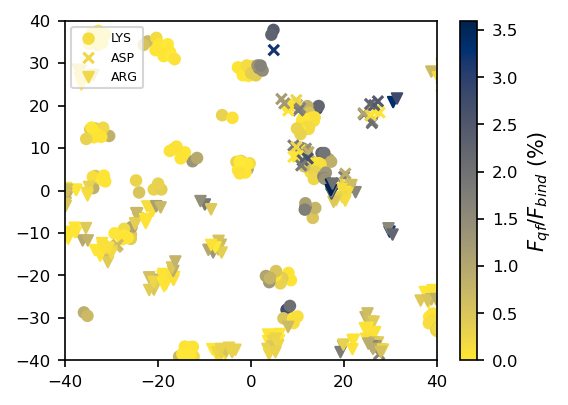

In [24]:
# identify amino acids names or chains
types = []
for j in range(amino_acid_name.shape[0]):
    if amino_acid_name[j] not in types:
        types.append(amino_acid_name[j])

# Plotting for each chain
#ASN, ASP, GLY
plane = 210 #-145.25
near_plane_abs = numpy.where(abs(position[:,0]-plane)<2.5)[0] #Plane between +-1 angstrom
f_tot_mag_386 = numpy.sqrt((-2.1197685475579964)**2+(0.36092747252832624)**2+(0.00760169067022572)**2)
near_plane_LYS = numpy.where(amino_acid_name[near_plane_abs] == b'LYS')[0] #Selecting atoms of the chain ASN
near_plane_ASP = numpy.where(amino_acid_name[near_plane_abs] == b'ASP')[0] #Selecting atoms of the chain ASP
near_plane_ARG = numpy.where(amino_acid_name[near_plane_abs] == b'ARG')[0] #Selecting atoms of the chain GLY

# Plotting
y_LYS = position[near_plane_abs[near_plane_LYS],1]
z_LYS = position[near_plane_abs[near_plane_LYS],2]
f_porcent_LYS = 100*(fl_mag_386[near_plane_abs[near_plane_LYS]])/(f_tot_mag_386)
y_ASP = position[near_plane_abs[near_plane_ASP],1]
z_ASP = position[near_plane_abs[near_plane_ASP],2]
f_porcent_ASP = 100*(fl_mag_386[near_plane_abs[near_plane_ASP]])/(f_tot_mag_386)
y_ARG = position[near_plane_abs[near_plane_ARG],1]
z_ARG = position[near_plane_abs[near_plane_ARG],2]
f_porcent_ARG = 100*(fl_mag_386[near_plane_abs[near_plane_ARG]])/(f_tot_mag_386)


plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(y_LYS,z_LYS,c=f_porcent_LYS,s=25,cmap='cividis_r',marker='o',vmin=0,vmax=3.6)
plt.scatter(y_ASP,z_ASP,c=f_porcent_ASP,s=25,cmap='cividis_r',marker='x',vmin=0,vmax=3.6)
plt.scatter(y_ARG,z_ARG,c=f_porcent_ARG,s=25,cmap='cividis_r',marker='v',vmin=0,vmax=3.6)
plt.xlim([-40,40]); plt.ylim([-40,40])
plt.legend(['LYS','ASP','ARG'],loc='upper left',prop={'size': 6})
plt.colorbar(label=r'$F_{qf}/F_{bind}$ (%) ')
plt.savefig('plots_aminoacid\\forces_qf_condelta_x={0}ang_{1}.pdf'.format(plane,'principal'), format='pdf',dpi=300,bbox_inches='tight')

In [7]:
# identify amino acids names or chains
types = []
for j in range(amino_acid_name.shape[0]):
    if amino_acid_name[j] not in types:
        types.append(amino_acid_name[j])

def get_f_porcent_planes(x_min,x_max, h,  fl_386, types, position, amino_acid_name):
    
    planes = numpy.arange(x_min,x_max,h) #Planes between +-h angstrom
    j = 0
    near_plane_chain = dict() 
    f_porcent_chain = dict()
    f_porcent_chain_mag = dict()
    #Set forces dictionary for each chain
    for chain in types:
        chain_name = chain.decode('utf-8')
        f_porcent_chain_mag[chain_name] = numpy.zeros(planes.shape)
        f_porcent_chain[chain_name] = numpy.zeros([int(planes.shape[0]),3])

    #Calculate forces between planes and chains
    for plane in planes:
        near_plane_abs = numpy.where(abs(position[:,0]-plane)<h/2)[0] #Plane between +-5 angstrom
        f_tot_mag_386 = numpy.sqrt((-2.1197685475579964)**2+(0.36092747252832624)**2+(0.00760169067022572)**2)
        for chain in types:
            chain_name = chain.decode('utf-8')
            near_plane_chain[chain_name] = numpy.where(amino_acid_name[near_plane_abs] == chain)[0] #Selecting atoms of the chain 
            f_porcent_chain[chain_name][j] = numpy.sum(fl_386[near_plane_abs[near_plane_chain[chain_name]]],axis=0)
            f_porcent_chain_mag[chain_name][j] = 100*(numpy.sqrt(numpy.sum(f_porcent_chain[chain_name][j]**2)))/(f_tot_mag_386)
        j += 1
    return planes, f_porcent_chain, f_porcent_chain_mag


<Figure size 432x288 with 0 Axes>

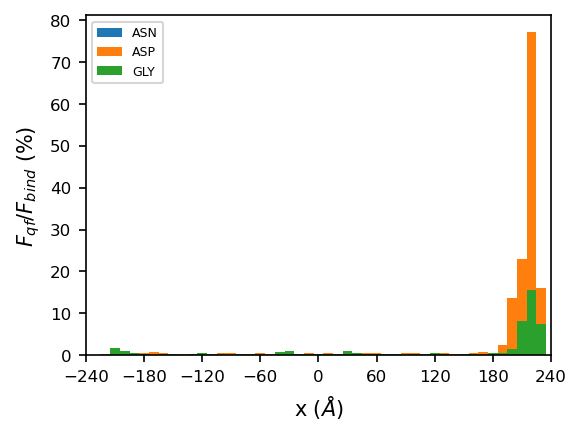

In [8]:
h= 10
planes, f_porcent_chain,f_porcent_chain_mag = get_f_porcent_planes(-240,240,h,fl_386,types,position,amino_acid_name)

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes, f_porcent_chain_mag['ASN'],width=h,label='ASN')
plt.bar(planes, f_porcent_chain_mag['ASP'],width=h,label='ASP')
plt.bar(planes, f_porcent_chain_mag['GLY'],width=h,label='GLY')
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$'); plt.ylabel(r'$F_{qf}/F_{bind}$ (%) ')
plt.xlim([-240,240]); plt.xticks(numpy.arange(-240,250,60))
plt.savefig('plots_aminoacid\\forces_qf_condelta_bar.pdf', format='pdf',dpi=300,bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

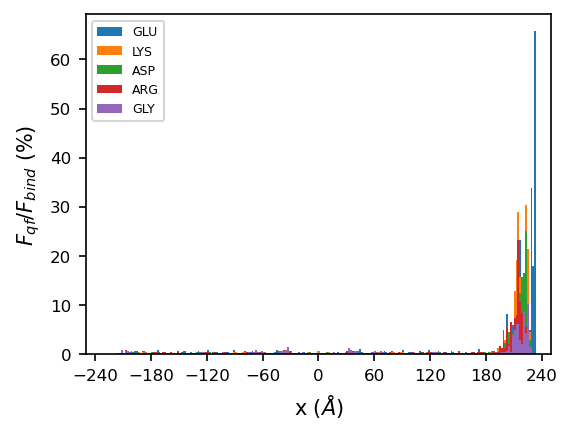

In [9]:
h= 2
planes, f_porcent_chain,f_porcent_chain_mag = get_f_porcent_planes(-285,285,h,fl_386,types,position,amino_acid_name)

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes, f_porcent_chain_mag['GLU'],width=h,label='GLU') 
plt.bar(planes, f_porcent_chain_mag['LYS'],width=h,label='LYS') 
plt.bar(planes, f_porcent_chain_mag['ASP'],width=h,label='ASP') 
plt.bar(planes, f_porcent_chain_mag['ARG'],width=h,label='ARG') 
plt.bar(planes, f_porcent_chain_mag['GLY'],width=h,label='GLY')
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$'); plt.ylabel(r'$F_{qf}/F_{bind}$ (%) ')
plt.xlim([-250,250]); plt.xticks(numpy.arange(-240,250,60))
plt.savefig('plots_aminoacid\\forces_qf_condelta_bar_2.pdf', format='pdf',dpi=300,bbox_inches='tight')
plt.show()

In [10]:
f_porcent_chain_mag

{'ILE': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 8.49981094e-04, 2.08776665e-03,
        7.11343904e-03, 5.63510578e-03, 2.44696085e-02, 3.28614431e-02,
        5.79641533e-02, 1.26340070e-01, 5.26834785e-02, 8.54712923e-02,
        1.64773817e-01, 6.00763671e-02, 5.18988994e-02, 3.41407481e-02,
        3.70268640e-02, 1.14367269e-02, 4.62181279e-02, 9.23878268e-02,
        4.94539221e-02, 8.05477941e-02, 6.51017686e-02, 2.44820972e-02,
        7.91149503e-02, 2.73036339e-02, 1.65027954e-01, 6

<Figure size 432x288 with 0 Axes>

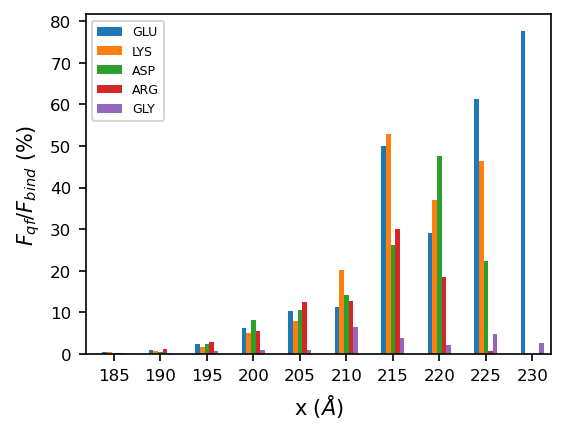

In [47]:
h=5
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8
planes,f_porcent_chain, f_porcent_chain_mag = get_f_porcent_planes(-240,240,h,fl_386,types,position,amino_acid_name)

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, f_porcent_chain_mag['GLU'],width=h/10,label='GLU') 
plt.bar(planes-h/10, f_porcent_chain_mag['LYS'],width=h/10,label='LYS') 
plt.bar(planes, f_porcent_chain_mag['ASP'],width=h/10,label='ASP') 
plt.bar(planes+h/10, f_porcent_chain_mag['ARG'],width=h/10,label='ARG') 
plt.bar(planes+2*h/10, f_porcent_chain_mag['GLY'],width=h/10,label='GLY')

'''
Max force in chain ARG: 37.24
Max force in chain GLY: 15.63
Max force in chain ASP: 77.35
Max force in chain GLU: 117.05
Max force in chain LYS: 94.30
'''

plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'$F_{qf}/F_{bind}$ (%) ')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.savefig('plots_aminoacid\\forces_qf_condelta_bar_{0}.pdf'.format(h), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

In [50]:
#count amino_acid_name in the file
n_aminoacid = dict()
for aminoacid in types:
    aminoacid_name = aminoacid.decode('utf-8')
    n_aminoacid[aminoacid_name] = len(numpy.where(aminoacid == amino_acid_name)[0])
    
    

In [63]:
n_aminoacid

{'ILE': 96120,
 'ARG': 99360,
 'CYX': 21600,
 'GLY': 71820,
 'VAL': 118080,
 'SER': 87300,
 'ASN': 45360,
 'ASP': 53952,
 'PHE': 68400,
 'GLU': 78180,
 'MET': 58140,
 'THR': 115920,
 'TRP': 56160,
 'LEU': 188100,
 'HIE': 58140,
 'ALA': 85140,
 'GLN': 48960,
 'LYS': 126632,
 'PRO': 47880,
 'TYR': 49140,
 'CYS': 1980,
 'LYN': 84,
 'ASH': 52,
 'GLH': 128}

In [62]:
numpy.array(n_aminoacid.values())[1]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [53]:
sum(n_aminoacid.values())

1576628

In [52]:
len(atom_name)

1576628

In [12]:
# Find each Carbono alpha "CA" in position
CA_index = numpy.where(atom_name == b'CA')[0]
pos_CA = dict()
for index in CA_index:
    aminoacid = amino_acid_name[index].decode('utf-8')
    number = amino_acid_number[index]
    ch = chain[index].decode('utf-8')
    if '{0} {1} {2}'.format(aminoacid,ch,str(number)) in pos_CA:
        continue
    pos_CA['{0} {1} {2}'.format(aminoacid,ch,str(number))] = position[index]

In [13]:
pos_CA

{'ILE A 1': array([-159.515,  -65.576, -129.445]),
 'ARG A 2': array([-158.956,  -69.358, -129.075]),
 'CYX A 3': array([-156.037,  -69.19 , -126.522]),
 'ILE A 4': array([-158.072,  -66.376, -124.795]),
 'GLY A 5': array([-159.612,  -69.038, -122.422]),
 'VAL A 6': array([-156.336,  -70.87 , -121.513]),
 'SER A 7': array([-154.753,  -70.822, -118.   ]),
 'ASN A 8': array([-151.286,  -71.246, -119.641]),
 'ARG A 9': array([-151.993,  -68.439, -122.159]),
 'ASP A 10': array([-148.722,  -66.55 , -122.243]),
 'PHE A 11': array([-148.532,  -63.182, -124.082]),
 'VAL A 12': array([-145.758,  -61.907, -126.442]),
 'GLU A 13': array([-145.208,  -58.279, -127.521]),
 'GLY A 14': array([-142.268,  -56.243, -128.889]),
 'MET A 15': array([-140.514,  -57.081, -132.215]),
 'SER A 16': array([-137.099,  -56.702, -133.955]),
 'GLY A 17': array([-137.538,  -53.568, -136.123]),
 'GLY A 18': array([-141.336,  -54.178, -135.732]),
 'THR A 19': array([-140.911,  -57.152, -138.202]),
 'TRP A 20': array([-

In [14]:
position, q, amino_acid_name, amino_acid_number, atom_name,chain

(array([[-158.378,  -64.7  , -129.804],
        [-159.515,  -65.576, -129.445],
        [-159.178,  -66.976, -129.96 ],
        ...,
        [ -91.22 ,  146.41 ,   73.082],
        [ -91.007,  149.585,   75.407],
        [ -90.401,  146.744,   72.613]]),
 array([ 0.031,  0.026,  0.612, ..., -0.651, -0.813,  0.447]),
 array([b'ILE', b'ILE', b'ILE', ..., b'SER', b'SER', b'SER'], dtype='|S32'),
 array([ 1,  1,  1, ..., 75, 75, 75]),
 array([b'N', b'CA', b'C', ..., b'OG', b'OXT', b'HG'], dtype='|S32'),
 array([b'A', b'A', b'A', ..., b'F', b'F', b'F'], dtype='|S32'))

In [15]:
for keys in f_porcent_chain_mag.keys():
    print('Max force in chain %s: %.2f' %(keys,max(f_porcent_chain_mag[keys])))

Max force in chain ILE: 7.55
Max force in chain ARG: 37.24
Max force in chain CYX: 2.91
Max force in chain GLY: 15.63
Max force in chain VAL: 5.95
Max force in chain SER: 9.18
Max force in chain ASN: 12.73
Max force in chain ASP: 77.35
Max force in chain PHE: 1.03
Max force in chain GLU: 117.05
Max force in chain MET: 1.34
Max force in chain THR: 6.82
Max force in chain TRP: 4.09
Max force in chain LEU: 2.52
Max force in chain HIE: 2.07
Max force in chain ALA: 3.80
Max force in chain GLN: 4.34
Max force in chain LYS: 94.30
Max force in chain PRO: 2.05
Max force in chain TYR: 9.14
Max force in chain CYS: 0.03
Max force in chain LYN: 0.01
Max force in chain ASH: 0.04
Max force in chain GLH: 0.34
